In [ ]:
from __future__ import (absolute_import, division, print_function, unicode_literals)

import os.path  # To manage paths

import pandas as pd
import pwb_toolbox.datasets as pwb_ds
import sqlalchemy as sa
import backtrader as bt

from dotenv import load_dotenv
load_dotenv()

%matplotlib inline

True

In [6]:
DB_URI = f'postgresql://{os.environ["PG_USER"]}:{os.environ["PG_PASS"]}@{os.environ["PG_URL"]}/{os.environ["PG_DB"]}'

try:
    engine = sa.create_engine(DB_URI)
    query = '''
        SELECT  datetime, symbol, adj_open as open, adj_close as close, adj_high as high, adj_low as low, volume
        FROM    stocks_daily_price
        WHERE   symbol='F';
    '''
    df = pd.read_sql_query(query, engine, parse_dates=['datetime'], index_col='datetime')
    print(df.info())
except Exception as e:
    print(f"An error occurred: {e}")
finally:
    if 'engine' in locals():
        engine.dispose()

data = bt.feeds.PandasData(dataname=df)

An error occurred: (psycopg2.errors.UndefinedColumn) column "datetime" does not exist
LINE 2:         SELECT  datetime, symbol, adj_open as open, adj_clos...
                        ^

[SQL: 
        SELECT  datetime, symbol, adj_open as open, adj_close as close, adj_high as high, adj_low as low, volume
        FROM    stocks_daily_price
        WHERE   symbol='F';
    ]
(Background on this error at: https://sqlalche.me/e/20/f405)


In [ ]:
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.maperiod)

        # Indicators for the plotting show
        bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)
        bt.indicators.WeightedMovingAverage(self.datas[0], period=25, subplot=True)
        # bt.indicators.StochasticSlow(self.datas[0])
        bt.indicators.MACDHisto(self.datas[0])
        rsi = bt.indicators.RSI(self.datas[0])
        bt.indicators.SmoothedMovingAverage(rsi, period=10)
        bt.indicators.ATR(self.datas[0], plot=False)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

In [8]:
cerebro = bt.Cerebro()

# Add a strategy
# strats = cerebro.optstrategy( TestStrategy, maperiod=range(10, 31) )
cerebro.addstrategy(TestStrategy)

# Add Data
cerebro.adddata(data)

cerebro.broker.setcash(1000.0)

# Add a FixedSize sizer according to the stake
cerebro.addsizer(bt.sizers.FixedSize, stake=10)

cerebro.broker.setcommission(commission=0.0)

print(f'Starting Portfolio Value: {cerebro.broker.getvalue()}')

cerebro.run()

print(f'Final Portfolio Value: {cerebro.broker.getvalue()}')

# Run over everything
cerebro.run(maxcpus=8)


Starting Portfolio Value: 1000.0
2024-08-01, Close, 10.46
2024-08-01, Close, 10.47
2024-08-01, BUY CREATE, 10.47
2024-08-01, BUY EXECUTED, Price: 10.46, Cost: 104.60, Comm 0.00
2024-08-01, Close, 10.47
2024-08-01, Close, 10.45
2024-08-01, SELL CREATE, 10.45
2024-08-01, SELL EXECUTED, Price: 10.46, Cost: 104.60, Comm 0.00
2024-08-01, OPERATION PROFIT, GROSS -0.03, NET -0.03
2024-08-01, Close, 10.46
2024-08-01, Close, 10.46
2024-08-01, Close, 10.46
2024-08-01, Close, 10.47
2024-08-01, BUY CREATE, 10.47
2024-08-01, BUY EXECUTED, Price: 10.46, Cost: 104.65, Comm 0.00
2024-08-01, Close, 10.46
2024-08-01, SELL CREATE, 10.46
2024-08-01, SELL EXECUTED, Price: 10.46, Cost: 104.65, Comm 0.00
2024-08-01, OPERATION PROFIT, GROSS -0.10, NET -0.10
2024-08-01, Close, 10.46
2024-08-01, Close, 10.45
2024-08-01, Close, 10.45
2024-08-01, Close, 10.47
2024-08-01, BUY CREATE, 10.47
2024-08-01, BUY EXECUTED, Price: 10.46, Cost: 104.64, Comm 0.00
2024-08-01, Close, 10.47
2024-08-01, Close, 10.46
2024-08-01, 

<IPython.core.display.Javascript object>

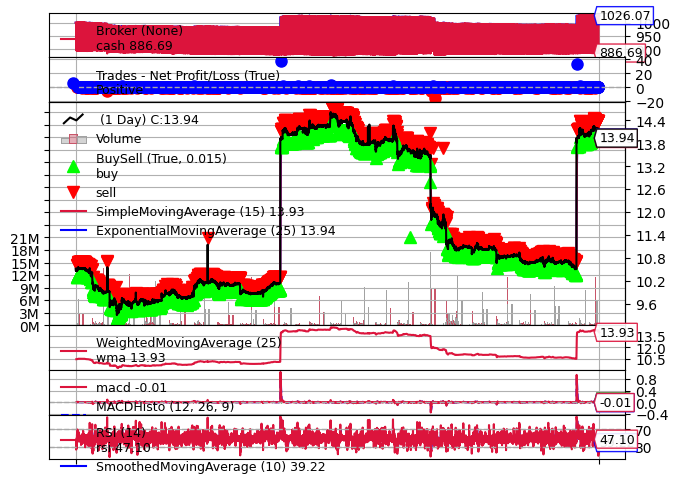

In [9]:
cerebro.plot()[0][0]